In [65]:
import pandas as pd
import numpy as np
import datetime

#n월 n주차 구하기
def week_no(y, m, d):
    #연월일을 입력받아 해당 요일의 주차를 얻는 함수
    '''y(int) - 연도 m(int) - 월 d(int) - 일, return : 해당 요일의 주(int)
    '''
    def _ymd_to_datetime(y, m, d): # 3
        """ 연월일을 입력받아 datetime 객체로 변환하는 함수
        Args:
        y (int) - 연도
        m (int) - 월
        d (int) - 일

        Return:
        datetime - YYYY-MM-DD 형식의 datetime 객체
        """
        s = f'{y:04d}-{m:02d}-{d:02d}'
        return datetime.datetime.strptime(s, '%Y-%m-%d')

    target_day = _ymd_to_datetime(y, m, d) # 4
    firstday = target_day.replace(day=1) # 5
    while firstday.weekday() != 0: # 6
        firstday += datetime.timedelta(days=1)
    if target_day < firstday: # 7
        return 0
  
    return (target_day - firstday).days // 7 + 1 # 8

#print(str(week_no(2022, 3, 1))) test용 print()

#요일 계산기
def cal_day(y, m, d):
    #days = ["월", "화", "수", "목", "금", "토", "일"]
    #토 : 5 일 : 6
    #b = days[datetime.date(y, m, d).weekday()]
    b = datetime.date(y, m, d).weekday()
    return b
#print(cal_day(2022, 3, 19))

#급여 계산용 함수
def cal_pay(name, ):
    payment = 0
    return payment

df = pd.read_excel('22.02.worksheet.xlsx')

#print(df['Unnamed: 2'][3:-1]) 날짜
#print(df['Unnamed: 3'][3:-1]) 근무인원
#print(df['Unnamed: 4'][3:-1]) 근무태그
#workLoad = np.array(df['Unnamed: 5'][3:-1]) 근무량
#print(df['Unnamed: 7'][3:-1]) 출근시간
#print(df['Unnamed: 8'][3:-1]) 퇴근시간
#print(df['Unnamed: 9'][3:-1]) 비고


workDay = np.array(df['Unnamed: 2'][3:-1])
name = np.array(df['Unnamed: 3'][3:-1])
workTag = np.array(df['Unnamed: 4'][3:-1])
workLoad = np.array(df['Unnamed: 5'][3:-1])
inRecord = np.array(df['Unnamed: 7'][3:-1])
outRecord = np.array(df['Unnamed: 8'][3:-1])
etc = np.array(df['Unnamed: 9'][3:-1])

tempList = []
peopleList = []
for index in range(0,len(name)):
    tempList.append(workDay[index])
    tempList.append(name[index])
    tempList.append(workTag[index])
    tempList.append(inRecord[index])
    tempList.append(outRecord[index])
    tempList.append(workLoad[index])
    tempList.append(etc[index])
    peopleList.append(tempList)
    tempList = []


commuteDf = pd.DataFrame(peopleList)
print(commuteDf)
commuteDf.to_excel("testResult.xlsx", index = False )

#개인별 월별 급여내역서 만들기
wage = [ 9160, 9500, 10000] #0 : 2022 최저 시급(수습), 1 : 현재 시급, 2 : 반장님 시급
dateformat = "%H:%M" #시간 계산 포맷

for n in name :
    tempList = []
    personData = []
    sumWorkload = 0 #총 검수량
    sumWorktime = 0 #총 검수 시간
    sumWage = 0 #총 급여
    tempList.append("성함 : ")
    tempList.append(n)
    personData.append(tempList)
    personData.append([])
    
    tempList = []
    tempList.append("날짜")
    tempList.append("근무파트")
    tempList.append("출근")
    tempList.append("퇴근")
    tempList.append("근무시간")
    tempList.append("검수평균")
    tempList.append("비 고")
    personData.append(tempList)
    
    #주차별 근무 시간 기록용 dictionary
    workTimeWeek_dict = {}
    workTimeWeek_dict[0] = 0 #1주차 총 근무 시간
    workTimeWeek_dict[1] = 0 #2주차 총 근무 시간
    workTimeWeek_dict[2] = 0 #3주차 총 근무 시간
    workTimeWeek_dict[3] = 0 #4주차 총 근무 시간
    workTimeWeek_dict[4] = 0 #5주차 총 근무 시간
    
    #주차별 근무 성과 기록용 dictionary
    workLoadWeek_dict = {}
    workLoadWeek_dict[0] = 0 #1주차 총 근무 성과
    workLoadWeek_dict[1] = 0 #2주차 총 근무 성과
    workLoadWeek_dict[2] = 0 #3주차 총 근무 성과
    workLoadWeek_dict[3] = 0 #4주차 총 근무 성과
    workLoadWeek_dict[4] = 0 #5주차 총 근무 성과
    
    
    countWeek = -1 #주차 체크 변수
    sumWorktime_week = 0 #주차 별 근무 시간
    sumWorkload_week = 0 #주차 별 검수량
    sumWage_week = 0 #주차 별 급여
    for person in peopleList :
        if person[1] == n :
            #주차 기록
            WORKDAY = str(person[0])[5:7] + str(person[0])[8:10] #날짜 기록
            
            if countWeek != week_no( 2022,int(WORKDAY[0:2]),int(WORKDAY[2:4])):
                #주차가 바뀌는 파트
                countWeek = week_no( 2022, int(WORKDAY[0:2]), int(WORKDAY[2:4]))
                if countWeek > 0 :
                    #주차 별 결산 기록
                    tempList = []
                    personData.append(tempList)
                    tempList = []
                    tempList.append(str(countWeek) + "주차 결산 : ")
                    tempList.append("")
                    tempList.append("")
                    tempList.append("")
                    tempList.append(sumWorktime_week)
                    workTimeWeek_dict[countWeek] = sumWorktime_week
                    tempList.append(sumWorkload_week)
                    personData.append(tempList)
                    
                    #해당 주차 주휴수당 여부
                    weekBool1 = False #주 15시간 이상 주 40시간 미만 해당 여부
                    weekBool2 = False #주 40시간 이상 해당 여부
                    if int(sumWorktime_week) >= 15 and int(sumWorktime_week) < 40 :
                        weekBool1 = True
                    elif int(sumWorktime_week) >= 40 :
                        weekBool2 = True

                    tempList = []
                    if weekBool1 == False and weekBool2 == False:
                        tempList.append("주휴수당 여부(주 15시간 이상 40시간 미만) : ")
                        tempList.append("")
                        tempList.append("")
                        tempList.append("")
                        tempList.append("")
                        tempList.append("❌")
                        personData.append(tempList)
                        tempList = []
                        tempList.append("주휴수당 여부(주 40시간 이상) : ")
                        tempList.append("")
                        tempList.append("")
                        tempList.append("")
                        tempList.append("")
                        tempList.append("❌") 
                    if weekBool1 :
                        tempList.append("주휴수당 여부(주 15시간 이상 40시간 미만) : ")
                        tempList.append("")
                        tempList.append("")
                        tempList.append("")
                        tempList.append("")
                        tempList.append("⭕️")
                        personData.append(tempList)
                        tempList = []
                        tempList.append("주휴수당 여부(주 40시간 이상) : ")
                        tempList.append("")
                        tempList.append("")
                        tempList.append("")
                        tempList.append("")
                        tempList.append("❌") 
                    if weekBool2 : 
                        tempList.append("주휴수당 여부(주 40시간 이상) : ")
                        tempList.append("")
                        tempList.append("")
                        tempList.append("")
                        tempList.append("")
                        tempList.append("❌")
                        personData.append(tempList)
                        tempList = []
                        tempList.append("주휴수당 여부(주 15시간 이상 40시간 미만) : ")
                        tempList.append("")
                        tempList.append("")
                        tempList.append("")
                        tempList.append("")
                        tempList.append("⭕️")
                    personData.append(tempList)
                    #해당 주차 급여 계산
                    #사람 타입 별 계산
                    personWage = int(wage[1])
                    
                    #if weekBool1 == True :
                    #elif weekBool2 == True : 
                    #else :
                        #sumWage_week += personWage * 
                    sumWage_week += personWage * workTimeWeek_dict[countWeek]
                    
                    #토, 일 1.5배 계산
                    day_index = cal_day(2022, int(WORKDAY[0:2]), int(WORKDAY[2:4])

                    #공휴일은 비고에 HOL로 표기해서 1.5배로 계산
                    tempList = []
                    tempList.append("주차 별 급여 =======>")
                    tempList.append("")
                    tempList.append("")
                    tempList.append("")
                    tempList.append("")
                    tempList.append(sumWage_week)                   
                    sumWorktime_week = 0
                    sumWorkload_week = 0
                    sumWage_week = 0
                
                #다음 주차 마크 기록
                tempList = []
                personData.append(tempList)
                tempList = []
                tempList.append(str(countWeek + 1)+"주차")
                personData.append(tempList)
            #날짜 기록
            tempList = []
            tempList.append(WORKDAY)
            
            #출근 시간 기록
            tempList.append(person[2])
            INTIME = str(person[3])[0:5]
            tempList.append(INTIME)
            
            #퇴근 시간 기록
            OUTTIME = str(person[4])[0:5]
            tempList.append(OUTTIME)
            
            #근무 시간 계산
            intime_convert = datetime.datetime.strptime(INTIME, dateformat)
            outtime_convert = datetime.datetime.strptime(OUTTIME, dateformat)
            cal_worktime = (outtime_convert - intime_convert).seconds / 3600
            tempList.append(cal_worktime)
            sumWorktime += float(cal_worktime)
            sumWorktime_week += float(cal_worktime)
            
            #근무 주차 계산
            workWeek_dict[countWeek] += cal_worktime
            
            #총 검수 평균 계산
            WORKLOAD = str(person[5]).split(".")[0]
            if WORKLOAD == "알 수 없음" or WORKLOAD == "해당x":
                sumWorkload += 0
                sumWorkload_week += 0
                tempList.append(0)
            else : 
                sumWorkload += int(WORKLOAD)
                sumWorkload_week += int(WORKLOAD)
                tempList.append(WORKLOAD)
        
            tempList.append(person[6])
            personData.append(tempList)
    
    #마지막 주차 결산 기록
    countWeek = week_no( 2022, int(WORKDAY[0:2]), int(WORKDAY[2:4]))
    if countWeek > 0 :
        tempList = []
        personData.append(tempList)
        tempList = []
        tempList.append(str(countWeek+1) + "주차 결산 : ")
        tempList.append("")
        tempList.append("")
        tempList.append("")
        tempList.append(sumWorktime_week)
        tempList.append(sumWorkload_week)
        personData.append(tempList)
        
        #해당 주차 주휴수당 여부
        weekBool1 = False #주 15시간 이상 주 40시간 미만 해당 여부
        weekBool2 = False #주 40시간 이상 해당 여부
        if int(sumWorktime_week) >= 15 and int(sumWorktime_week) < 40 :
            weekBool1 = True
        elif int(sumWorktime_week) >= 40 :
            weekBool2 = True
        
        tempList = []
        if weekBool1 == False and weekBool2 == False:
            tempList.append("주휴수당 여부(주 15시간 이상 40시간 미만) : ")
            tempList.append("")
            tempList.append("")
            tempList.append("")
            tempList.append("")
            tempList.append("❌")
            personData.append(tempList)
            tempList = []
            tempList.append("주휴수당 여부(주 40시간 이상) : ")
            tempList.append("")
            tempList.append("")
            tempList.append("")
            tempList.append("")
            tempList.append("❌")
            personData.append(tempList)
        if weekBool1 :
            tempList.append("주휴수당 여부(주 15시간 이상 40시간 미만) : ")
            tempList.append("")
            tempList.append("")
            tempList.append("")
            tempList.append("")
            tempList.append("⭕️")
            personData.append(tempList)
            tempList = []
            tempList.append("주휴수당 여부(주 40시간 이상) : ")
            tempList.append("")
            tempList.append("")
            tempList.append("")
            tempList.append("")
            tempList.append("❌") 
            personData.append(tempList)
        if weekBool2 : 
            tempList.append("주휴수당 여부(주 40시간 이상) : ")
            tempList.append("")
            tempList.append("")
            tempList.append("")
            tempList.append("")
            tempList.append("❌")
            personData.append(tempList)
            tempList = []
            tempList.append("주휴수당 여부(주 15시간 이상 40시간 미만) : ")
            tempList.append("")
            tempList.append("")
            tempList.append("")
            tempList.append("")
            tempList.append("⭕️")
            personData.append(tempList)
        
        #해당 주차 급여 계산
        
        #토, 일 1.5배 계산
        day_index = cal_day(2022, int(WORKDAY[0:2]), int(WORKDAY[2:4])
        
        #공휴일은 비고에 HOL로 표기해서 1.5배로 계산
        tempList = []
        tempList.append("주차 별 급여 =======>")
        tempList.append("")
        tempList.append("")
        tempList.append("")
        tempList.append("")
        
        
        sumWorktime_week = 0
        sumWorkload_week = 0    
    personData.append([])
    tempList = []
    tempList.append("총 성과 : ") 
    tempList.append(sumWorkload/sumWorktime) #성과 평균 계산
    tempList.append("") #칸맞추기용
    tempList.append("")
    tempList.append(sumWorktime)
    tempList.append(sumWorkload)
    personData.append(tempList)
    
    personData.append([])
    tempList = []
    tempList.append("총 급여 : ")
    personData.append(tempList)
    
    personData.append([])
    tempList = []
    tempList.append("프리랜서 신고 후 금액 : ")
    personData.append(tempList)
    
    personalDf = pd.DataFrame(personData)
    personalDf.to_excel("./workData/" + n +"_월별 급여내역서.xlsx", index = False)
            

    

SyntaxError: invalid syntax (2092106289.py, line 222)

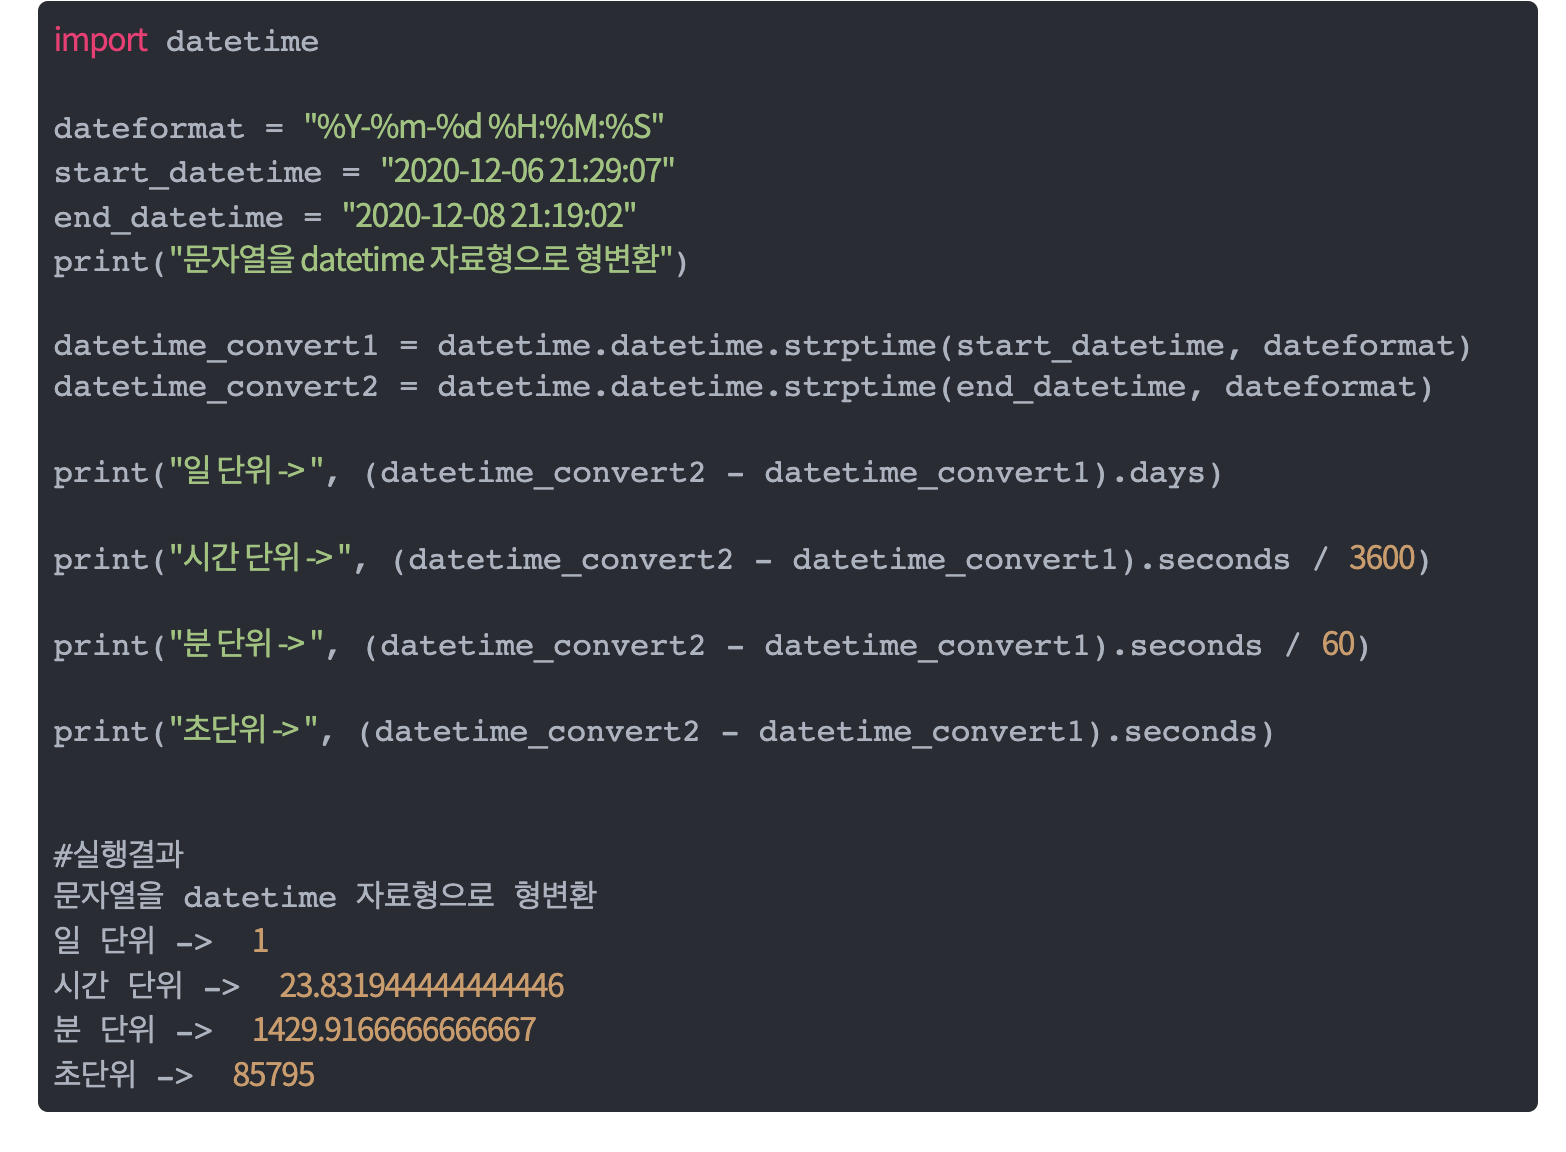
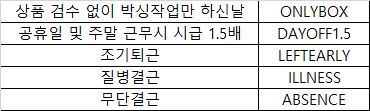